<a href="https://colab.research.google.com/github/ElizavetaRysyeva/ML_speech/blob/main/ASR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%pip install cudatoolkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement cudatoolkit (from versions: none)
ERROR: No matching distribution found for cudatoolkit


In [ ]:
%pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%pip install -U -q tensorflow tensorflow_datasets
#%apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 32.4 MB/s eta 0:00:00


In [ ]:
%pip install numba==0.53

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 35.2 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.39.1
    Uninstalling llvmlite-0.39.1:
      Successfully uninstalled llvmlite-0.39.1
  Attempting uninstall: numba
    Found existing installation: numba 0.56.4
    Uninstalling numba-0.56.4:
      Successfully uninstalled numba-0.56.4


## План

Содержание:<br>
* [1. Визуализация данных и ввод функций](#visualization)
   * [1.0. Импорт данных и очистка данных (удаление тишины и шумов)](#data)
   * [1.1. Волны и спектограммы](#waveandspectrogram)
      * [1.1.1 MFCC](#mfcc)
      * [1.1.2 Спектограмма в 3D](#3d)
      * [1.1.3 Средние спектрограммы и БПФ](#len)
* [2. Обучение модели](#modeledu)
    * [2.1 Оценка производительности модели ](#rate) 
    * [2.2 Матрица путницы ](#matrix) 
    * [2.3 Проверка прогноза ](#check) 



In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import pathlib

import tensorflow as tf

from os.path import isdir, join
from pathlib import Path
import pandas as pd


import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd


%matplotlib inline

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
from google.colab.patches import cv2_imshow


# 1. Визуализация
<a id="visualization"></a> 


## 1.0. Импорт набора данных
<a id="data"></a> 



Аудиоклипы набора данных хранятся в восьми папках, соответствующих каждой голосовой команде: no , yes , down , go , left , up , right и stop :

In [ ]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 6s 0us/step


In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['up' 'down' 'no' 'left' 'right' 'go' 'yes' 'stop']


In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/yes/881583a6_nohash_0.wav', shape=(), dtype=string)


In [ ]:
filename = '/yes/0ab3b47d_nohash_0.wav'
sample_rate, samples = wavfile.read(str(DATASET_PATH) + filename)

## Очистка данных (удаление тишины и шумов)

In [ ]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [ ]:
ipd.Audio(samples, rate=sample_rate)

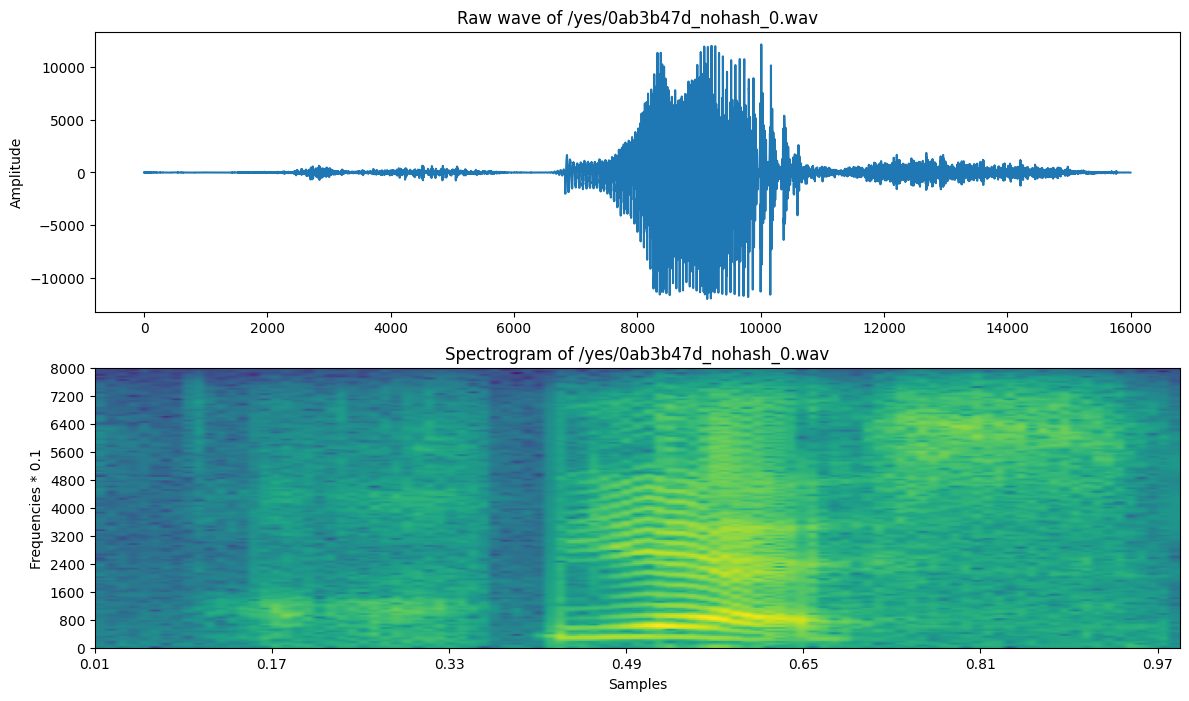

In [ ]:
freqs, times, spectrogram_cut = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
plt.show()

Вырежем часть файла с начала и с конца. и послушайте это снова (основываясь на приведенном выше графике, мы берем от 4000 до 13000):

In [ ]:
samples_cut = samples[6500:13000]
ipd.Audio(samples_cut, rate=sample_rate)

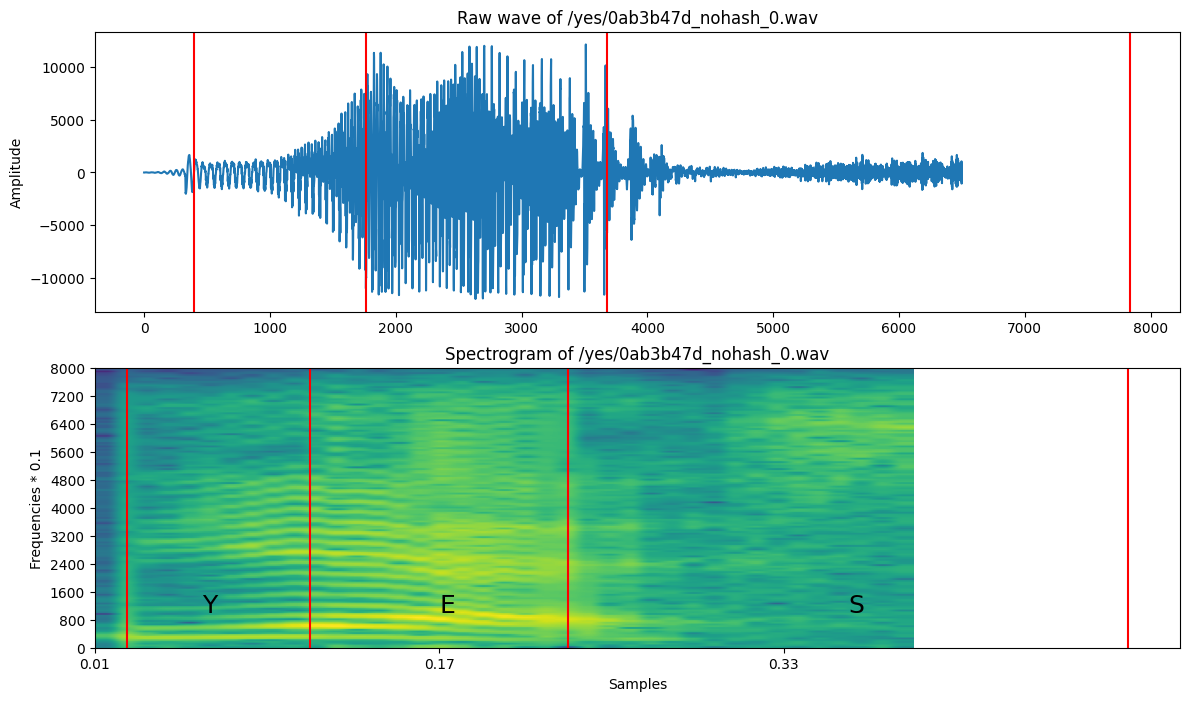

In [ ]:
freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')

## 1.1. Волны и спектограммы
<a id="waveandspectrogram"></a> 

Сигналы в наборе данных представлены во временной области. Преобразуете формы сигналов из сигналов во временной области в сигналы в частотно-временной области путем вычисления кратковременного преобразования Фурье (STFT) для преобразования сигналов в виде спектрограмм , которые показывают изменения частоты во времени и могут быть представлены в виде 2D-изображений. 


Text(0.5, 0, 'Секунды')

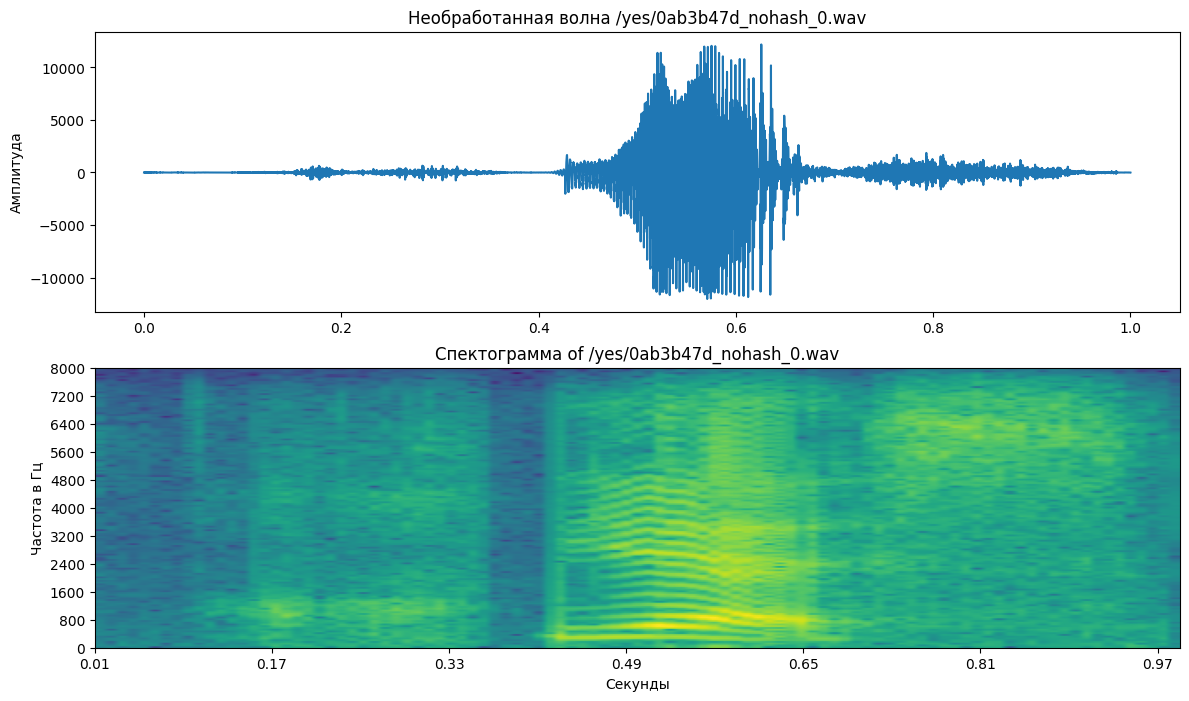

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Необработанная волна ' + filename)
ax1.set_ylabel('Амплитуда')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Спектограмма of ' + filename)
ax2.set_ylabel('Частота в Гц')
ax2.set_xlabel('Секунды')


Частоты находятся в диапазоне (0,8000) согласно теореме Найквиста.


In [ ]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

In [ ]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

## 1.1.1 MFCC
<a id="mfcc"></a> 

Спектрограмма мела — это спектрограмма, в которой частоты преобразуются в шкалу мела

In [ ]:
samples, sample_rate = librosa.load(str(DATASET_PATH)+filename)

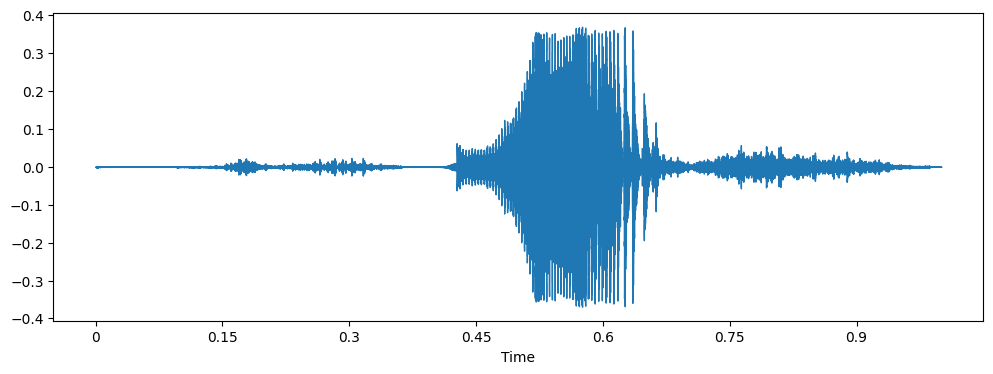

In [ ]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(samples.astype('float'), sr=sample_rate)
plt.show()

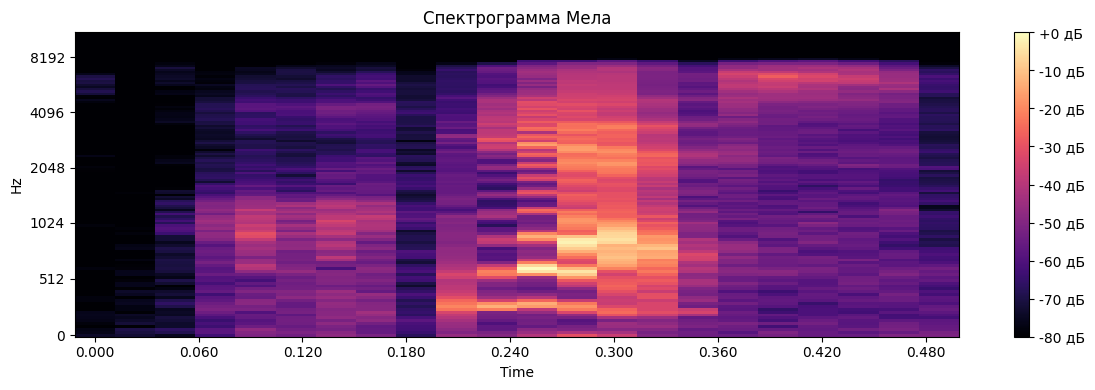

In [ ]:
S = librosa.feature.melspectrogram(y=samples, sr=sample_rate, n_fft=2048, hop_length=1024) 

log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Спектрограмма Мела'); 
plt.colorbar(format='%+2.0f дБ');
plt.tight_layout()

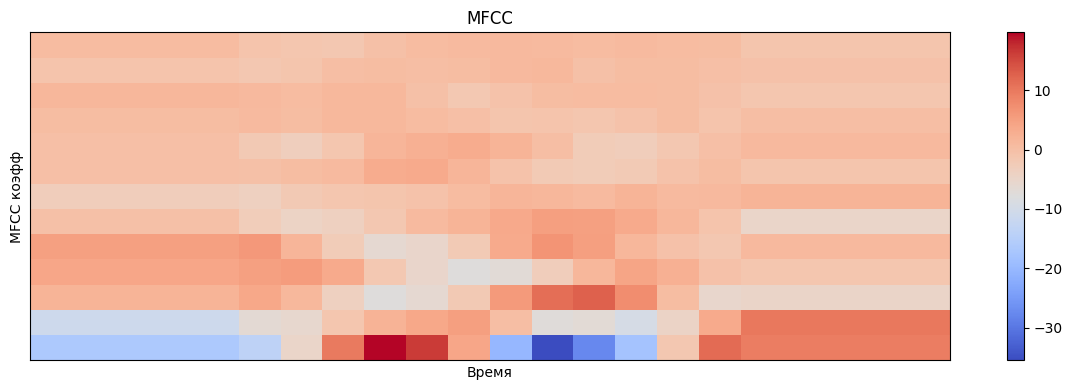

In [ ]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC коэфф')
plt.xlabel('Время')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

## 1.1.2 Спектограмма команды в 3D
<a id="3d"></a> 


In [ ]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

data = [go.Surface(z=spectrogram.T)]

layout = go.Layout(
    title='Спектограмма команды "yes" в 3D')

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)


### 1.1.3 Средние спектрограммы и FFT
<a id="meanspectrogramsandfft"></a> 

 FFT симметричен, поэтому мы берем только первую половину
 
 FFT также сложен, поскольку мы берем только действительную часть (abs)

In [ ]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  
    return xf, vals

In [ ]:
dirs = [f for f in os.listdir(DATASET_PATH) if isdir(join(DATASET_PATH, f))]



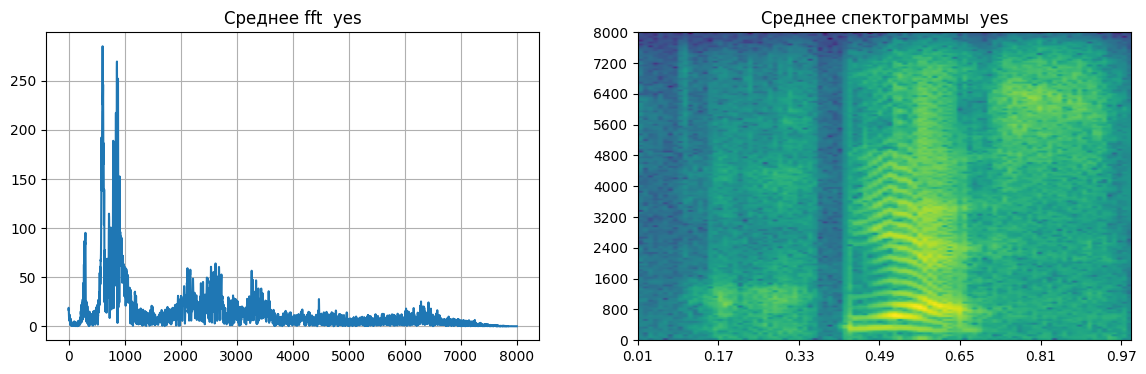

In [ ]:
to_keep = 'yes'.split()
dirs = [d for d in dirs if d in to_keep]

for direct in dirs:
    vals_all = []
    spec_all = []

    waves = [f for f in os.listdir(join(DATASET_PATH, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(str(DATASET_PATH) + filename)

        xf, vals = custom_fft(samples, 16000)
        vals_all.append(vals)
        freqs, times, spec = log_specgram(samples, 16000)
        spec_all.append(spec)

    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.title('Среднее fft  ' + direct)
    plt.plot(np.mean(np.array(vals_all), axis=0))
    plt.grid()
    plt.subplot(122)
    plt.title('Среднее спектограммы  ' + direct)
    plt.imshow(np.mean(np.array(spec_all), axis=0).T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.show()

# 2. Обучение модели
<a id="modeledu"></a> 

Разделим filenames на обучающие, проверочные и тестовые наборы, используя соотношение 80:10:10 соответственно:

In [ ]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Размер тренировочного набора', len(train_files))
print('Размер набора для проверки', len(val_files))
print('Размер тестового набора', len(test_files))

Размер тренировочного набора 6400
Размер набора для проверки 800
Размер тестового набора 800


In [ ]:
test_file = tf.io.read_file(DATASET_PATH+'/yes/0ab3b47d_nohash_0.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([16000, 1])

Определим функцию, которая предварительно обрабатывает необработанные аудиофайлы WAV набора данных в аудиотензоры:

In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  return tf.squeeze(audio, axis=-1)

Определим функцию, которая создает метки, используя родительские каталоги для каждого файла:

* Разделим пути к файлам на tf.RaggedTensor s (тензоры с рваными размерами — с кусочками, которые могут иметь разную длину

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  return parts[-2]

Определите  вспомогательную функцию — get_waveform_and_label 

* В качестве входных данных используется имя аудиофайла WAV.

* Выходные данные представляют собой кортеж, содержащий тензоры аудио и меток, готовые к обучению с учителем.

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

Преобразования Фурье (STFT)
Оно необходимо для преобразования сигналов в виде спектрограмм , которые показывают изменения частоты во времени и могут быть представлены в виде 2D-изображений. 

Создадим функцию для преобразования сигналов в спектрограммы:

In [ ]:
def get_spectrogram(waveform):
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  waveform = tf.cast(waveform, dtype=tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Определим функцию, которая преобразует набор данных сигнала в спектрограммы и соответствующие им метки в виде целочисленных идентификаторов:

In [ ]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Пакетное обучение и наборы проверки для обучения модели:

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Создадим модель для классификации звуковых команд. 
Он будет использовать спектрограммы звуковых файлов в качестве входных данных, нормализовать их и пропускать через несколько сверточных слоев и полносвязных слоев, чтобы получить выходные данные, которые представляют вероятности принадлежности к каждому из заданных классов. 
Функция model.summary() выводит сводку модели, включая количество параметров и форму каждого слоя.

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = layers.Normalization()
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

Модель состоит из последовательности слоев. Входной тензор имеет форму (124, 129, 1). Первый слой - Resizing, изменяет размер входного изображения до (32, 32, 1). Затем следует слой Normalization, нормализующий значения пикселей в диапазоне [0, 1]. Далее идут два сверточных слоя Conv2D с функцией активации ReLU и фильтрами размера 3x3, соответственно с 32 и 64 фильтрами. После этого следует слой MaxPooling2D с ядром размера 2x2, который уменьшает размерность выхода вдвое. Затем добавлен слой Dropout для регуляризации модели. Следующий слой - Flatten, преобразует выходные данные из предыдущего слоя в одномерный массив. Далее идет полносвязный слой Dense с 128 нейронами и функцией активации ReLU. Снова добавлен слой Dropout для регуляризации. И наконец, последний полносвязный слой Dense с одним нейроном и функцией активации sigmoid, который будет использоваться для бинарной классификации. Общее количество параметров модели - 1,625,611. Все параметры модели обучаемые.

Настроим модель Keras с помощью оптимизатора Adam и кросс-энтропийной потери:
Этот код компилирует модель нейронной сети, определяя оптимизатор, функцию потерь и метрики для оценки производительности модели во время обучения. Оптимизатор Adam используется для обновления весов модели в процессе обучения. 

Функция потерь SparseCategoricalCrossentropy используется для оценки разницы между предсказанными и истинными метками классов. 

Метрики 'accuracy' используются для оценки точности классификации модели.

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Обучим модель на обучающем наборе данных (train_ds) и оценим ее производительность на валидационном наборе данных (val_ds) в течение a-эпох. 
Будем использовать обратный вызов EarlyStopping, который прерывает обучение, если модель перестает улучшаться на валидационном наборе данных после двух эпох. Результаты обучения сохраняются в объекте history.

In [ ]:
a = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=a,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 41s 394ms/step - loss: 1.7495 - accuracy: 0.3695 - val_loss: 1.2645 - val_accuracy: 0.6162
Epoch 2/10
100/100 [==============================] - 45s 446ms/step - loss: 1.1864 - accuracy: 0.5789 - val_loss: 0.9157 - val_accuracy: 0.6800
Epoch 3/10
100/100 [==============================] - 42s 422ms/step - loss: 0.8861 - accuracy: 0.6861 - val_loss: 0.7318 - val_accuracy: 0.7563
Epoch 4/10
100/100 [==============================] - 40s 395ms/step - loss: 0.7273 - accuracy: 0.7448 - val_loss: 0.6438 - val_accuracy: 0.7800
Epoch 5/10
100/100 [==============================] - 45s 447ms/step - loss: 0.6105 - accuracy: 0.7856 - val_loss: 0.5970 - val_accuracy: 0.8050
Epoch 6/10
100/100 [==============================] - 40s 397ms/step - loss: 0.5199 - accuracy: 0.8219 - val_loss: 0.5502 - val_accuracy: 0.8025
Epoch 7/10
100/100 [==============================] - 42s 419ms/step - loss: 0.4636 - accuracy: 0.8373 - val_loss: 0.5290 - val_ac

В первой эпохе точность на обучающем наборе составляет 0.3630, а на валидационном - 0.5763. В результате обучения точность на обучающем наборе постепенно увеличивается, достигая в конце 0.8589, а на валидационном наборе - 0.8363. 


Построим график функции потерь (loss) на обучающем и валидационном наборах данных в течение эпох обучения. График позволяет оценить производительность модели и определить, насколько хорошо она обучается на данных. 

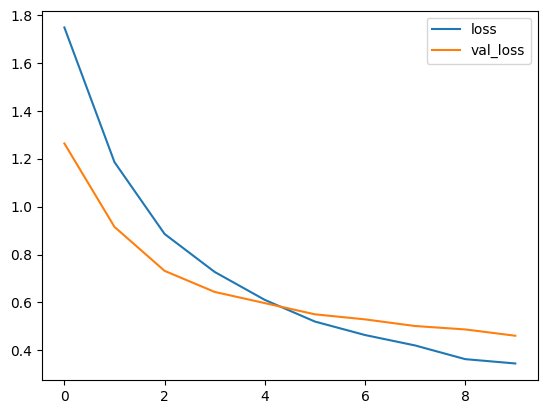

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

Функция потерь на обучающем и валидационном наборах данных уменьшается, это означает, что модель продолжает улучшаться и лучше подстраивается под данные. Это хороший признак того, что модель обучается эффективно и может достичь хороших результатов на новых данных.

## 2.1 Оценка модели
<a id="rate"></a> 

Выполним тестирование модели на тестовом наборе данных. Код будет проходить через каждый элемент тестового набора данных и добавляет аудио и метки в соответствующие списки. Затем использовать модель для предсказания меток для каждого аудиофайла в тестовом наборе и сравнивает предсказанные метки с реальными метками из тестового набора. 

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

25/25 [==============================] - 1s 31ms/step
Test set accuracy: 84%


Модель, протестированная на тестовом наборе данных, правильно предсказала метки для 84% аудиофайлов в тестовом наборе. 

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['f1_score'],
)

In [ ]:
from sklearn.metrics import f1_score
testaudio = []
testlabels = []

for audio, label in test_ds:
  testaudio.append(audio.numpy())
  testlabels.append(label.numpy())

test_audio = np.array(testaudio)
test_labels = np.array(testlabels)

ypred = np.argmax(model.predict(test_audio), axis=1)
ytrue = test_labels

testf1score = f1_score(ytrue, ypred, average='weighted')
print(f'Test set F1 score: {testf1score:.2f}')

25/25 [==============================] - 1s 52ms/step
Test set F1 score: 0.84


In [ ]:

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

def custom_loss(y_true, y_pred):
    return loss_fn(y_true, y_pred, from_logits=True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=custom_loss,
    metrics=[tf.keras.metrics.Precision()],
)


test_audio = []
test_labels = []

for audio, label in test_ds:
  testaudio.append(audio.numpy())
  testlabels.append(label.numpy())

testaudio = np.array(test_audio)
testlabels = np.array(test_labels)

ypred = np.argmax(model.predict(test_audio), axis=1)
ytrue = testlabels

testprecision = tf.keras.metrics.Precision()(ytrue, ypred)
print(f'Test set precision: {testprecision:.0%}')

25/25 [==============================] - 2s 60ms/step
Test set precision: 99%





## 2.2 Матрица путаницы
<a id="matrix"></a> 

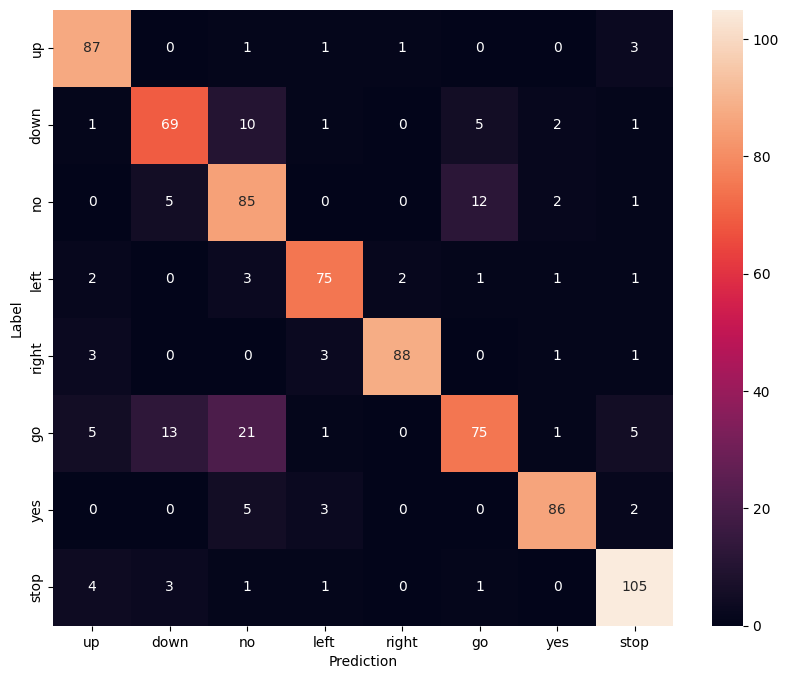

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Этот код загружает звуковой файл, преобразует его в спектрограмму и использует обученную модель для предсказания класса звука. Затем он отображает график с вероятностями принадлежности к каждому классу и названием класса, который был предсказан для данного звукового файла.
## 2.3 Проверка прогноза
<a id="check"></a> 

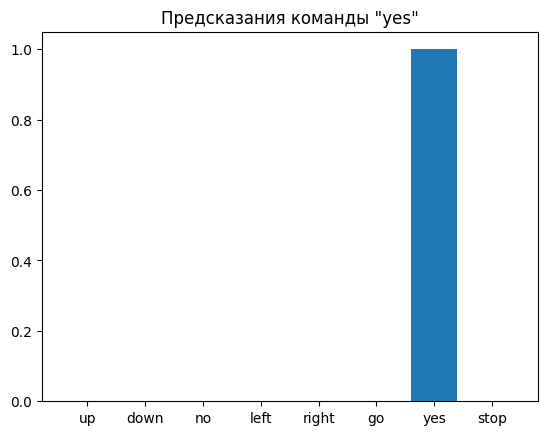

In [ ]:
sample_file = data_dir/'yes/0ab3b47d_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Предсказания команды "{commands[label[0]]}"')
  plt.show()

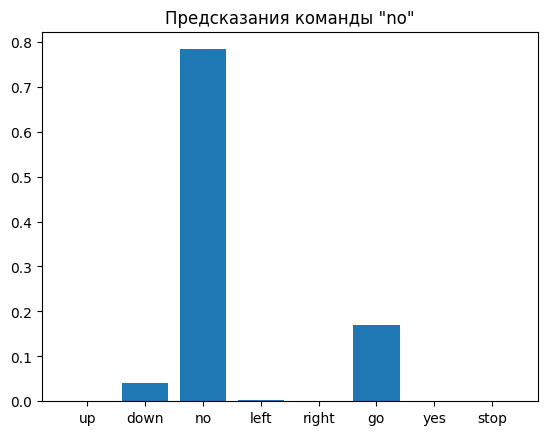

In [ ]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Предсказания команды "{commands[label[0]]}"')
  plt.show()

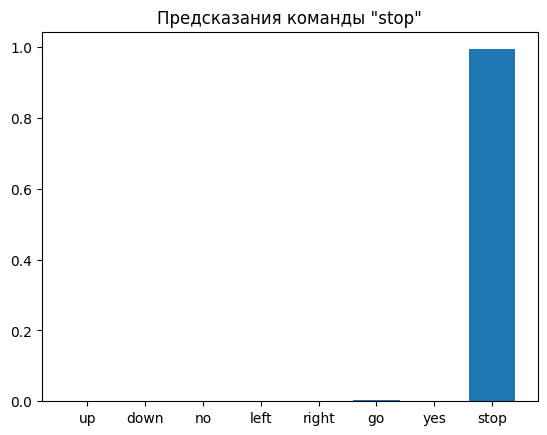

In [ ]:
sample_file = data_dir/'stop/0cd323ec_nohash_1.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Предсказания команды "{commands[label[0]]}"')
  plt.show()

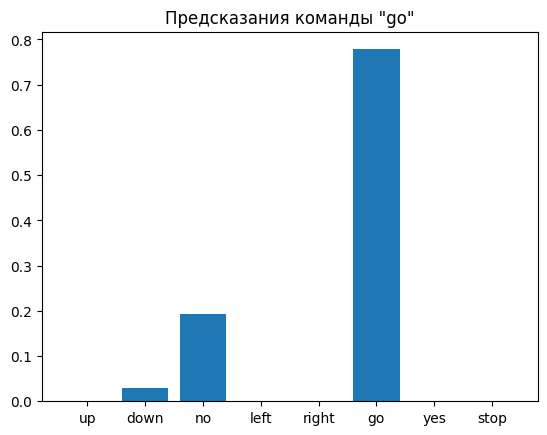

In [ ]:
sample_file = data_dir/'go/0a9f9af7_nohash_1.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Предсказания команды "{commands[label[0]]}"')
  plt.show()

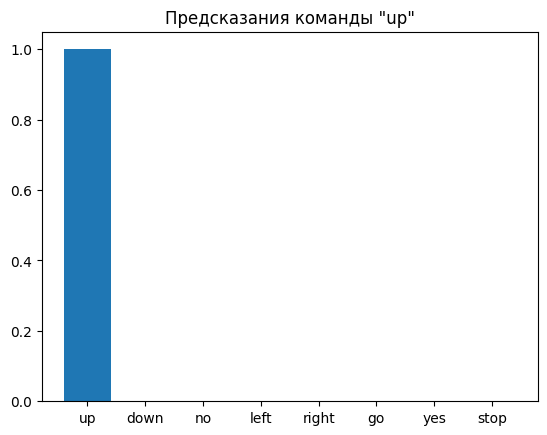

In [ ]:
sample_file = data_dir/'up/0ab3b47d_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Предсказания команды "{commands[label[0]]}"')
  plt.show()

Как мы видим, что наша модель работает верно, то слова, которое мы проверяли она распознала.